# Pattern Matching 4 - Video, Matching & Tracking

**Objectives**

* Analyze video sequences
* Match objects between frames for tracking

## Video import

[Download](https://my.pcloud.com/publink/show?code=XZpIUMkZQX7lwSh8BPpO5vF6UWC6xSXgVLRy) the images from the video sequence, and the supervised segmentation ground truth: 

(Reference: http://groups.inf.ed.ac.uk/f4k/PAPERS/VIGTA2012.pdf)

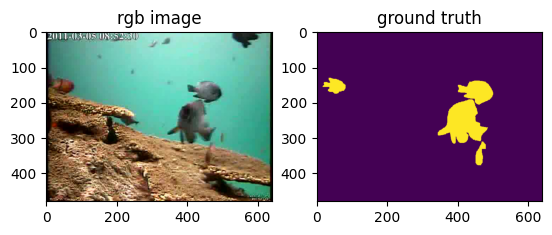

In [72]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
import os

vid_path = '../data/Video/'
gt_path = '../data/GroundTruth/'

seq0 = [685,705]
seq1 = [1173,1191]

for no in range(*seq1):
    fid = os.path.join(vid_path,'frame%04d.jpg'%no)
    rgb = imread(fid)    
    
    fid =  os.path.join(gt_path,'%d.png'%no)
    supervision = imread(fid)
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.title('rgb image')
    plt.imshow(rgb)
    plt.subplot(1,2,2)
    plt.imshow(supervision)
    plt.title('ground truth')
    break #stop after one frame for test purpose

## Background image (Video segmentation)

When analyzing video sequences, we can use the *movement of the frame* to help our object segmentation. In this video, our goal is to segment the fish from the background. The background here is the part of the image that doesn't change from frame to frame: detecting the objects can therefore be done using **background subtraction**.

Implement the background subtraction algorithm:

1. Initialize background image: $B_{0} = I_{0}$ where $I_t$ is the image at time $t$ and $B$ is the estimated background. 
2. Update background: $B_{t} = \alpha B_{t-1} + (1-\alpha) I_t$
> What is the purpose of $\alpha$? How can you determine that your background estimation is "stable" and can be used?\
The $\alpha$ represent the amount of information that is kept from the previous frame. If $\alpha$ is too small, the background will change too quickly and will not be stable. If $\alpha$ is too large, the background will change too slowly and will not adapt to changes in the scene.
3. Subtract background to detect foreground: $F_t = I_t - B_t$
4. Find a good post-processing to clean-up the foreground image. Label the individual objects (fish).
5. Using the supervised part of the sequence, estimate the detection error of your algorithm.
> *Hint: useful metrics for segmentation performance include per-pixel accuracy, precision, recall, or F1-score (DICE). These measures can also be made per-object, which is slightly more difficult to compute but in many applications a better indicator of the actual performance of the algorithm.*

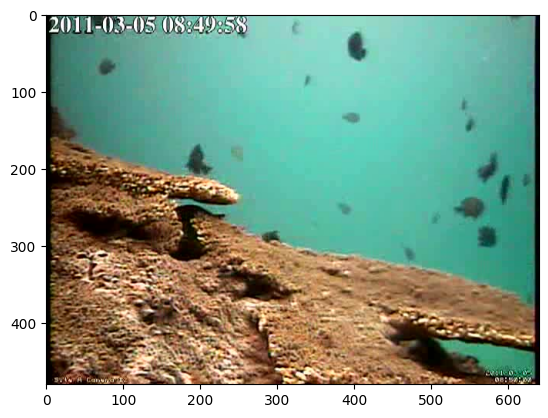

In [73]:
B = os.path.join(vid_path,'frame%04d.jpg'%1)
plt.figure()
plt.imshow(imread(B))
plt.show()


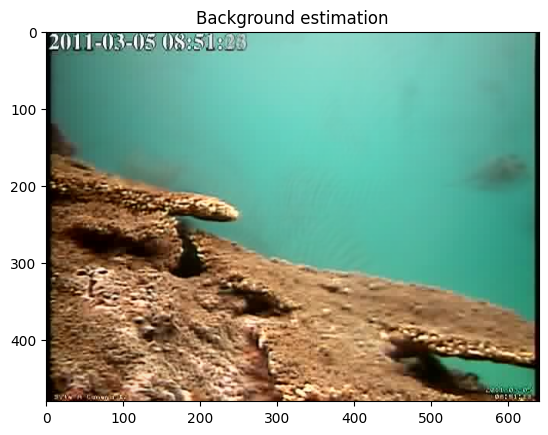

In [74]:
# Initialize B as the first frame image
B = imread(os.path.join(vid_path, 'frame0001.jpg')).astype(np.float32)

# Background estimation loop
alpha = 0.99
for i in range(2, seq0[0]):
    I = imread(os.path.join(vid_path, 'frame%04d.jpg' % i)).astype(np.float32)
    B = alpha * B + (1 - alpha) * I  # Update the background

# Convert B back to uint8 for visualization
B = B.astype(np.uint8)

plt.figure()
plt.imshow(B)
plt.title('Background estimation')
plt.show()

In [75]:
print(I.shape,I.dtype)
print(B.shape,B.dtype)
print(I)
print(B)

(480, 640, 3) float32
(480, 640, 3) uint8
[[[12.  0.  4.]
  [ 7.  0.  0.]
  [ 7.  0.  0.]
  ...
  [ 0.  6.  8.]
  [ 0.  4.  7.]
  [ 0.  4.  7.]]

 [[37. 25. 29.]
  [ 7.  0.  0.]
  [ 6.  0.  0.]
  ...
  [ 0.  6.  8.]
  [ 0.  4.  7.]
  [ 0.  4.  7.]]

 [[37. 26. 30.]
  [12.  3.  6.]
  [ 6.  0.  0.]
  ...
  [ 0.  6.  8.]
  [ 0.  4.  7.]
  [ 0.  4.  7.]]

 ...

 [[ 0.  3.  4.]
  [ 0.  3.  2.]
  [ 0.  2.  2.]
  ...
  [10.  0.  2.]
  [14.  0.  9.]
  [20.  4. 15.]]

 [[ 0.  3.  4.]
  [ 0.  3.  2.]
  [ 0.  2.  2.]
  ...
  [12.  0.  3.]
  [11.  0.  5.]
  [11.  0.  5.]]

 [[ 0.  3.  4.]
  [ 0.  3.  2.]
  [ 0.  2.  2.]
  ...
  [15.  0.  4.]
  [11.  0.  5.]
  [11.  0.  5.]]]
[[[ 1  5  5]
  [ 4 10 10]
  [ 3 11 11]
  ...
  [ 0 12  5]
  [ 0  9  4]
  [ 0 10  5]]

 [[17 26 26]
  [ 3  9 10]
  [ 0  4  4]
  ...
  [ 0 12  5]
  [ 0  9  4]
  [ 0 10  5]]

 [[24 33 33]
  [ 1  6  7]
  [ 0  3  4]
  ...
  [ 0 12  5]
  [ 0  9  4]
  [ 0 10  5]]

 ...

 [[ 7  0  2]
  [ 7  0  1]
  [ 7  0  1]
  ...
  [19  0  1]
  [21 

320.43253 0.0


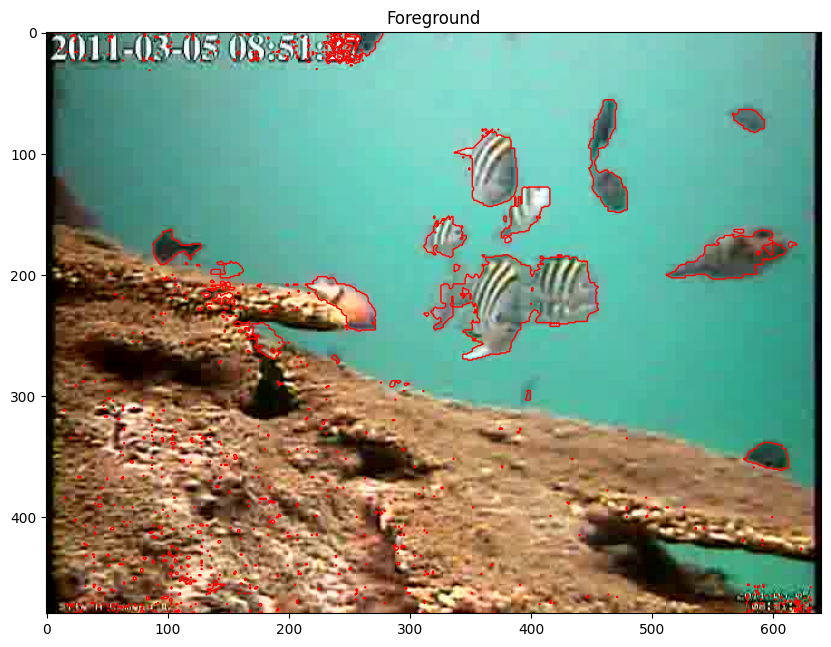

In [76]:
# trying remove the background
F = np.abs(I - B) #foreground = current frame - background
F = np.sqrt(np.sum((I-B)**2, axis=2)) # seconde method
print(F.max(),F.min())
fg_mask = F > 50 # create a mask for the foreground (binary image)
plt.figure(figsize=(10, 8))
plt.imshow(I/255) #apply a treshold
plt.contour(fg_mask, colors='r', linewidths=1) #draw the contour
plt.title('Foreground')
plt.show()

Ground Truth Mask Shape: (480, 640) Type: bool
Foreground Shape: (480, 640) Type: float32
Current Frame Shape: (480, 640, 3) Type: float32


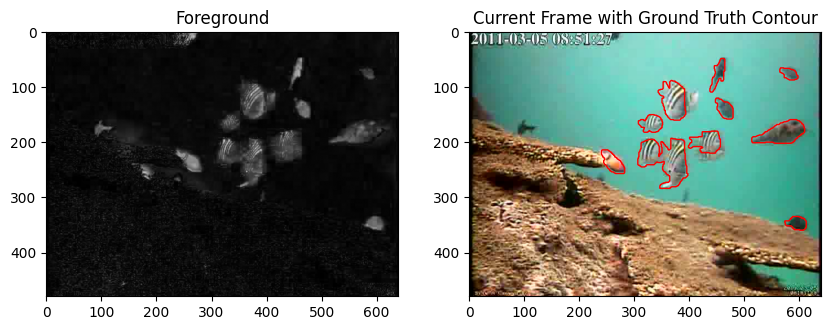

In [77]:
for f in range(*seq0):
    I = imread(os.path.join(vid_path, 'frame%04d.jpg' % f)).astype(np.float32)
    F = np.sqrt(np.sum((I - B) ** 2, axis=2))  # Foreground calculation
    S = imread(os.path.join(gt_path, '%d.png' % f)) > 0  # Ground truth mask
    print("Ground Truth Mask Shape:", S.shape, "Type:", S.dtype)
    print("Foreground Shape:", F.shape, "Type:", F.dtype)
    print("Current Frame Shape:", I.shape, "Type:", I.dtype)
    
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(F, cmap='gray')  # Display foreground
    plt.title('Foreground')
    plt.subplot(1, 2, 2)
    plt.imshow(I / 255)  # Normalize and display the current frame
    plt.contour(S, colors='r', linewidths=1)  # Draw ground truth contour
    plt.title('Current Frame with Ground Truth Contour')
    plt.show()
    break  # Stop after one frame for testing

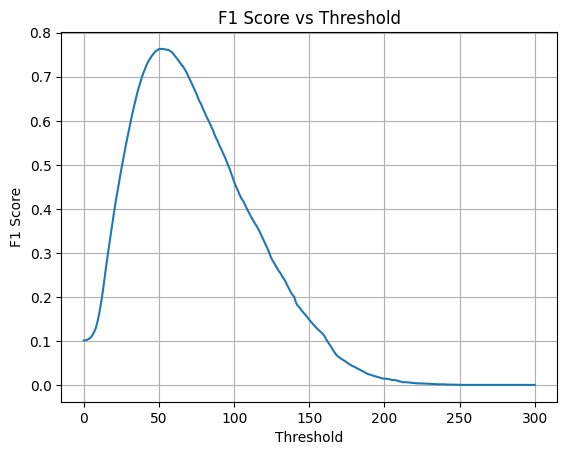

0.763288963970524


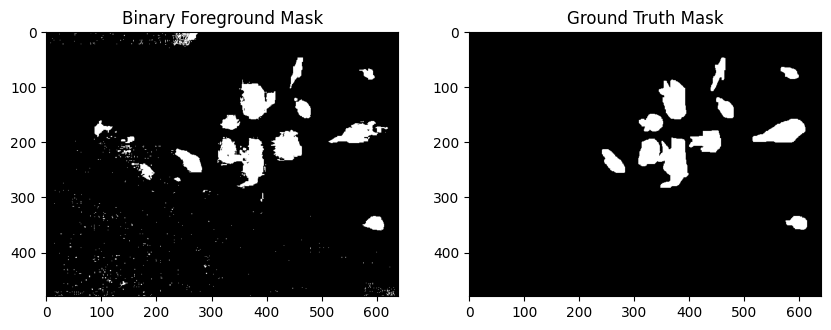

In [78]:
def F1(gt, pred):
    intersection = ((gt==1)*(pred==1)).sum()
    return 2*intersection/(gt.sum() + pred.sum())

f1s = []
for t in range(int(F.max())):
    f1s.append(F1(S, F > t))

plt.figure()
plt.plot(f1s)
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid()
plt.show()

t = np.argmax(f1s)  # Find the threshold with the maximum F1 score
P = F > t

print(F1(S, P))

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(P, cmap='gray')  # Display binary foreground mask
plt.title('Binary Foreground Mask')
plt.subplot(1, 2, 2)
plt.imshow(S, cmap='gray')  # Display ground truth mask
plt.title('Ground Truth Mask')
plt.show()

0.7723970148272348


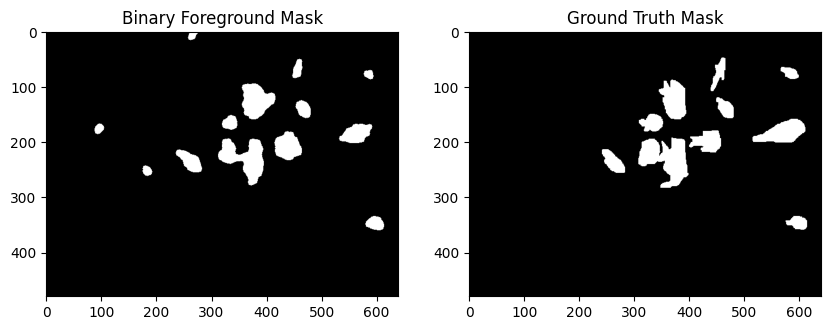

In [ ]:
# clean the mask with morphological operation
from skimage.morphology import opening, closing, disk

P2 = opening(P, disk(5))  # Morphological opening
P2 = closing(P2, disk(3))  # Morphological closing
print(F1(S, P2))

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(P2, cmap='gray')  # Display binary foreground mask
plt.title('Binary Foreground Mask')
plt.subplot(1, 2, 2)
plt.imshow(S, cmap='gray')  # Display ground truth mask
plt.title('Ground Truth Mask')
plt.show()

## Object tracking

1. Extract interesting features from the detected objects.
1. Suggest a method to recognise and track objects from one frame to the next frame.

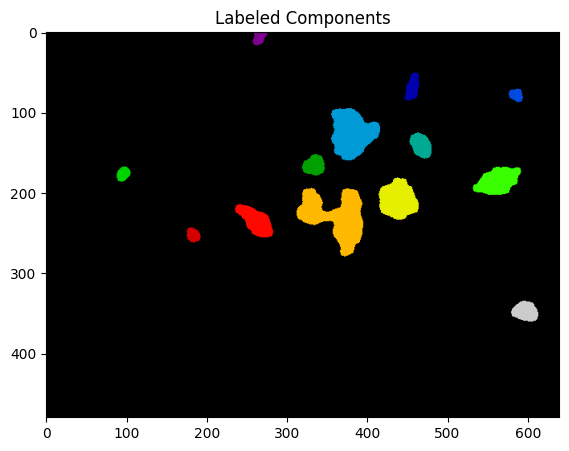

In [87]:
from skimage.measure import label

labels = label(P2)  # Label connected components

plt.figure(figsize=(10, 5))
plt.imshow(labels, cmap='nipy_spectral')  # Display labeled components
plt.title('Labeled Components')
plt.show()


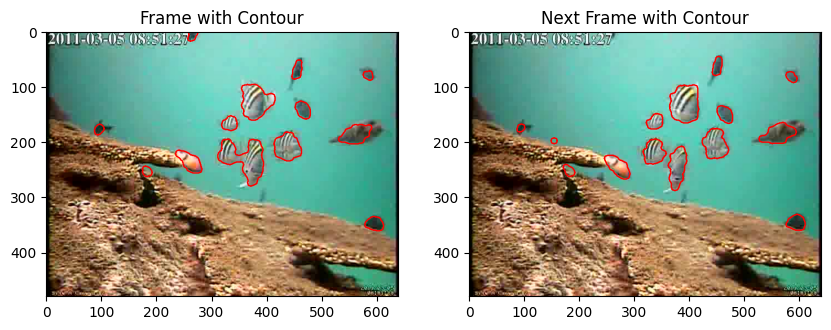

In [89]:
I_next = imread(os.path.join(vid_path, 'frame%04d.jpg' % (f + 1))).astype(np.float32)
F_next = np.sqrt(np.sum((I_next - B) ** 2, axis=2))  # Foreground calculation
S_next = imread(os.path.join(gt_path, '%d.png' % (f + 1))) > 0  # Ground truth mask

P_next = opening(F_next > t, disk(5))
P_next = closing(P_next, disk(3))

labels_next = label(P_next)  # Label connected components for the next frame

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(I / 255)  # Normalize and display the current frame
plt.contour(P2, colors='r', linewidths=1)  # Draw contour of the current frame
plt.title('Frame with Contour')
plt.subplot(1, 2, 2)
plt.imshow(I_next / 255)  # Normalize and display the next frame
plt.contour(P_next, colors='r', linewidths=1)  # Draw contour of the next frame
plt.title('Next Frame with Contour')
plt.show()

1 [0]


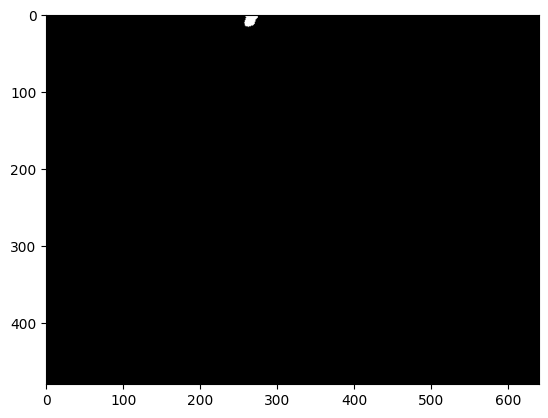

2 [0 1]


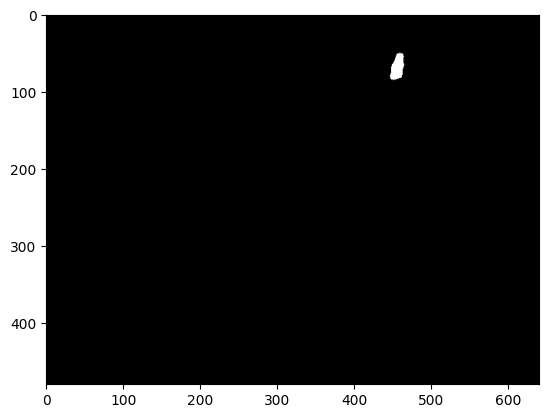

3 [0 2]


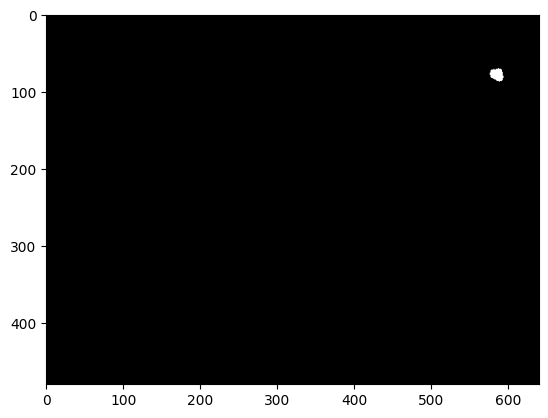

4 [0 3]


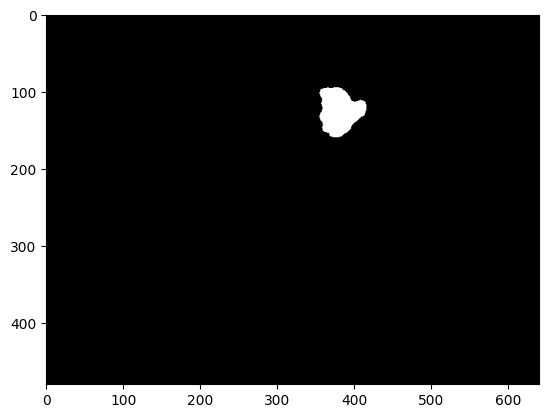

5 [0 4]


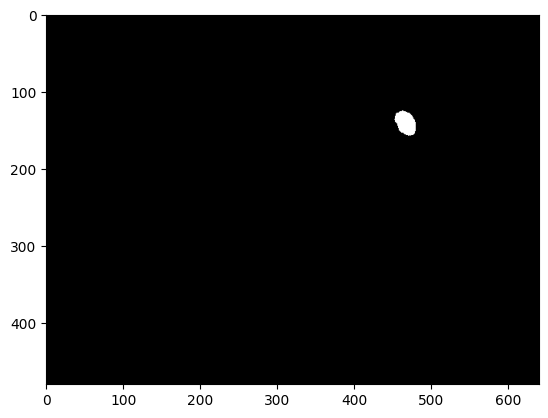

6 [0 5]


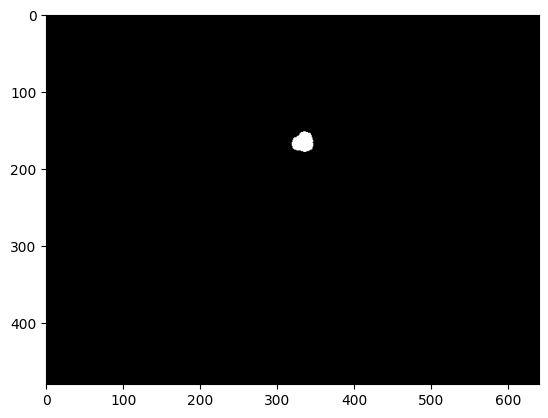

7 [0 7]


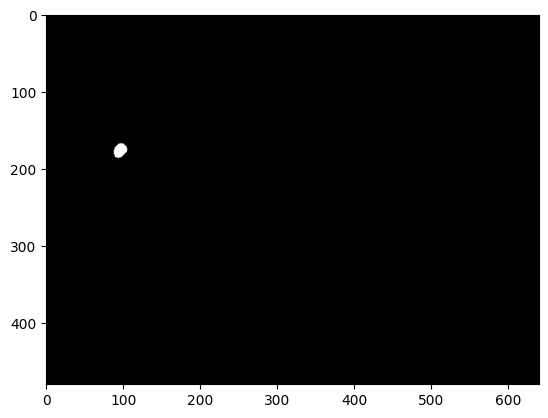

8 [0 6]


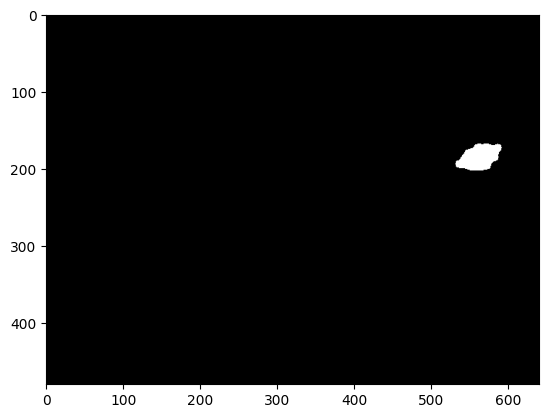

9 [0 8]


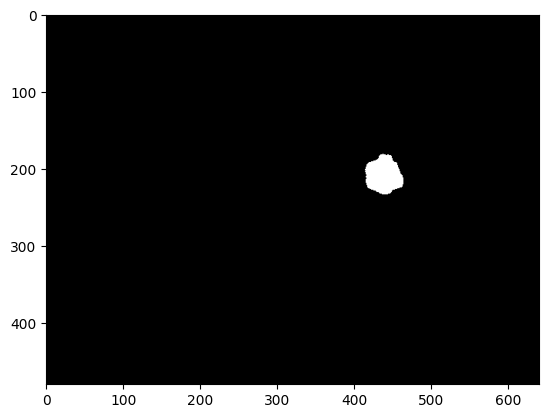

10 [ 0 10 11]


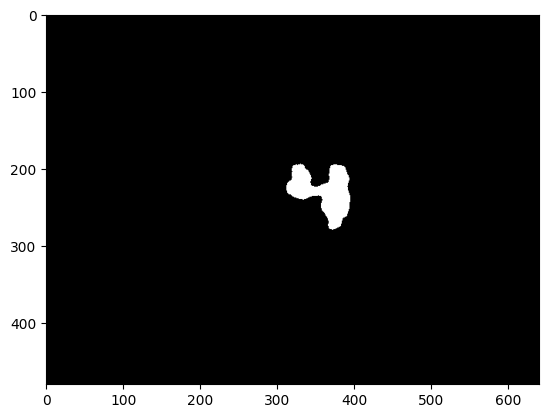

11 [ 0 12]


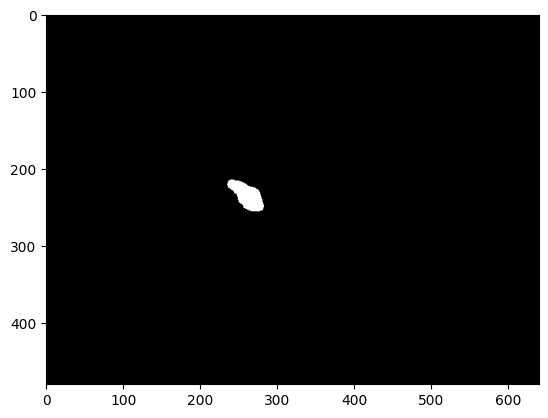

12 [ 0 13]


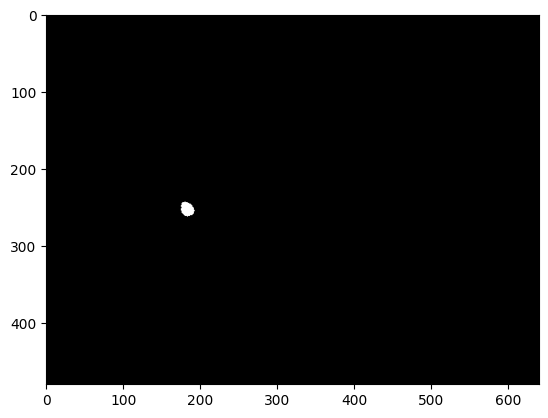

13 [ 0 14]


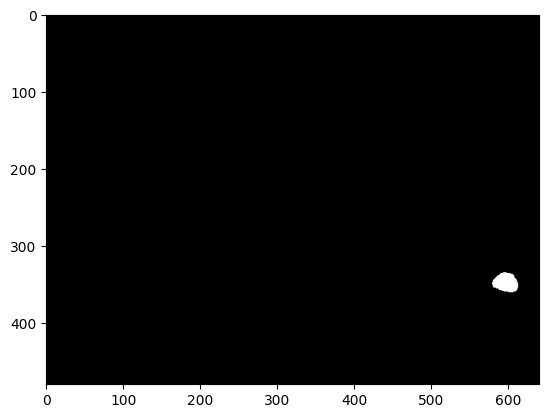

In [91]:
for lab in range(1, labels.max() + 1):
    matching_objects = np.unique(labels_next[labels==lab])
    print(lab,matching_objects)
    plt.figure()
    plt.imshow(labels==lab,cmap='gray')
    plt.show()